In [1]:
from Augmented_SSM import Augmented_SSM
import numpy as np
import pandas as pd
from dateutil import tz
from astral import Astral
from Utilities import *
from ModelTest import loadTestSets

In [8]:
colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]

# Simple tests

In [129]:
def gen_data(dt, Omega, Q, R, pi1, sigma1, T):
    """Generate data from a 1D augmented state space model.
    
    Args:
        dt (float): timestep
        Omega (1 x 1 numpy.array): nonzero component of the observation matrix. C is defined as (Omega 0).
        Q (2 x 2 numpy.array): hidden state noise covariance
        R (1 x 1 numpy.array): observation noise covariance
        pi1 (2 x 1 numpy.array): initial hidden state mean
        sigma1 (2 x 2 numpy.array): initial hidden state uncertainty
        T (int): number of observations/timesteps
        
    Returns:
        2 x T numpy.array, 1 x T numpy.array: hidden state and observation values
    
    """
    
    A = np.array([[1.0, dt], [0.0, 1.0]])
    
    x = np.zeros([2, T])
    x[:, 0] = np.random.normal(pi1, sigma1).flatten()
    
    for t in range(1, T):
        x[:, t] = np.dot(A, x[:, t-1]) + np.random.multivariate_normal(mean=[0, 0], cov=Q)

    # y_t = C x_t + delta, delta ~ N(0, R)
    y = np.dot(Omega, x[0:1, :]) + np.random.multivariate_normal(mean=[0], cov=R, size=[T]).T
    
    return x, y

## Scenario 1

In [141]:
dt = 0.25

Omega_1 = np.array([1.0]).reshape([1, 1])
Q_1 = 0.05 * np.identity(2)
R_1 = np.array([0.1]).reshape([1, 1])
pi1_1 = np.array([0.0, -0.1]).reshape([2, 1])
sigma1_1 = np.array([0.05]).reshape([1, 1])
T_1 = 100

x_1, y_1 = gen_data(dt, Omega_1, Q_1, R_1, pi1_1, sigma1_1, T_1)

### Augmented SSM EM

In [142]:
aug_ssm_1 = Augmented_SSM(y_1, dt, 1, v=np.zeros([1, T_1]))
aug_ssm_1.em(100)

# Get observation estimates and error band
y_hat_1 = aug_ssm_1.get_y_hat()
y_em_err_1 = np.einsum("ij,ki,tjk->it", aug_ssm_1.Cs[0], aug_ssm_1.Cs[0].T, aug_ssm_1.sigma_smooth)

# Print parameters
#aug_ssm_1.print_params()

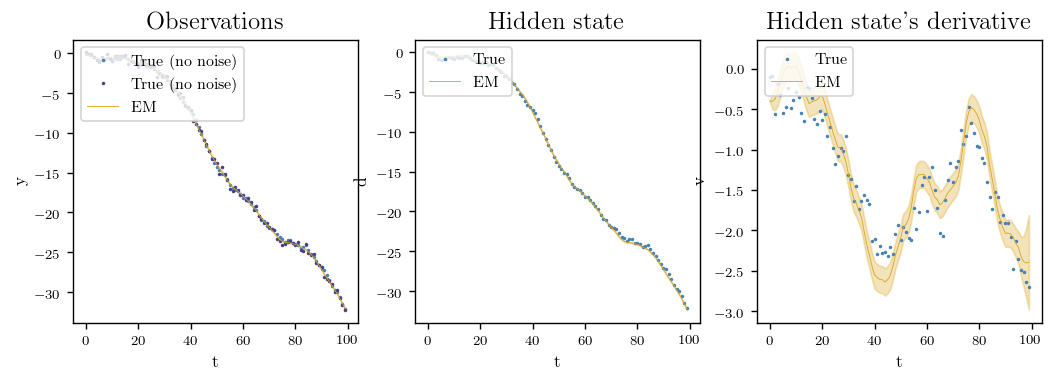

In [152]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)

# Plot data without noise
plt.plot(np.dot(Omega_1, x_1[0:1, :]).T, '.', color=colors[0], markersize=2, label="True (no noise)")
# Plot data with noise
plt.plot(y_1.T, '.', color=colors[5], markersize=2, label="True (no noise)")

# Plot smoothed state computed using EM
plt.plot(y_hat_1.T, color=colors[2], label="EM", linewidth=0.5)
plt.fill_between(range(T_1),
                 (y_hat_1 - 2*y_em_err_1).flatten().T,
                 (y_hat_1 + 2*y_em_err_1).flatten().T,
                 linewidth=1,
                 alpha=0.3,
                 color=colors[2])

plt.title("Observations")
plt.xlabel("t")
plt.ylabel("y")
plt.legend(loc="upper left")

########################

plt.subplot(1, 3, 2)

# Plot true hidden state
plt.plot(x_1[0, :].T, '.', color=colors[0], markersize=2, label="True")

# Plot infered hidden state with error bars
plt.plot(aug_ssm_1.x_smooth[0, :].T, color=colors[2], linewidth=0.5, label="EM")
plt.fill_between(range(T_1),
                 (aug_ssm_1.x_smooth[0, :] - 2*aug_ssm_1.sigma_smooth[:, 0, 0]).flatten().T,
                 (aug_ssm_1.x_smooth[0, :] + 2*aug_ssm_1.sigma_smooth[:, 0, 0]).flatten().T,
                 linewidth=1,
                 alpha=0.3,
                 color=colors[2])

plt.title("Hidden state")
plt.xlabel("t")
plt.ylabel("d")
plt.legend(loc="upper left")

########################

plt.subplot(1, 3, 3)

# Plot true hidden state's derivative
plt.plot(x_1[1, :].T, '.', color=colors[0], markersize=2, label="True")
# Plot infered hidden state's derivative
plt.plot(aug_ssm_1.x_smooth[1, :].T, color=colors[2], linewidth=0.5, label="EM")
plt.fill_between(range(T_1),
                 (aug_ssm_1.x_smooth[1, :] - 2*aug_ssm_1.sigma_smooth[:, 1, 1]).flatten().T,
                 (aug_ssm_1.x_smooth[1, :] + 2*aug_ssm_1.sigma_smooth[:, 1, 1]).flatten().T,
                 linewidth=1,
                 alpha=0.3,
                 color=colors[2])

plt.title("Hidden state's derivative")
plt.xlabel("t")
plt.ylabel("v")
plt.legend(loc="upper left")

### Compare with Kalman smoother

In [153]:
# Plug in true parameter values
aug_ssm_1.Bs = np.array([np.array([0]).reshape([1, 1])])
aug_ssm_1.Cs = np.array([np.asarray(np.bmat([Omega_1, np.zeros([1, 1])]))])
aug_ssm_1.Ds = np.array([np.array([0]).reshape([1, 1])]) # no sensor bias
aug_ssm_1.Qs = np.array([Q_1])
aug_ssm_1.Rs = np.array([R_1])
aug_ssm_1.pi1 = pi1_1.flatten()
aug_ssm_1.sigma1 = sigma1_1

# Run smoother
aug_ssm_1.smooth()
y_smooth = np.einsum("ij,jt->it", aug_ssm_1.Cs[0], aug_ssm_1.x_smooth)
y_smooth_err = np.einsum("ij,ki,tjk->it", aug_ssm_1.Cs[0], aug_ssm_1.Cs[0].T, aug_ssm_1.sigma_smooth)

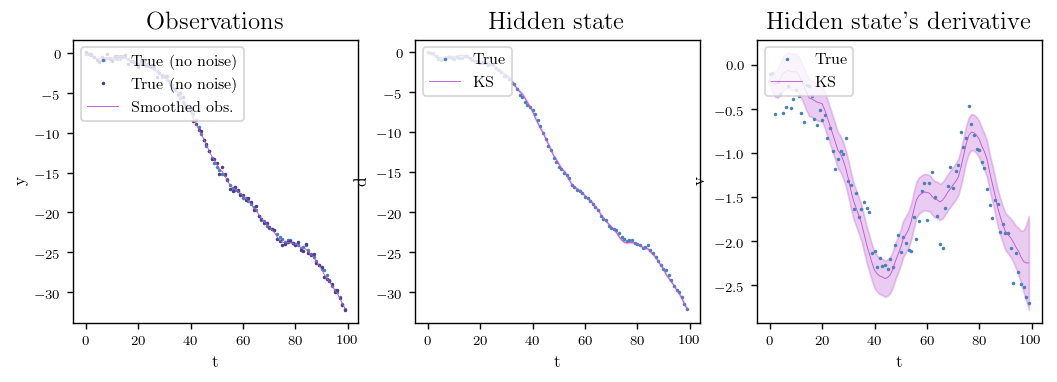

In [154]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)

# Plot data without noise
plt.plot(np.dot(Omega_1, x_1[0:1, :]).T, '.', color=colors[0], markersize=2, label="True (no noise)")
# Plot data with noise
plt.plot(y_1.T, '.', color=colors[5], markersize=2, label="True (no noise)")

# Plug in true parameter values
aug_ssm_1.Bs = np.array([np.array([0]).reshape([1, 1])])
aug_ssm_1.Cs = np.array([np.asarray(np.bmat([Omega_1, np.zeros([1, 1])]))])
aug_ssm_1.Ds = np.array([np.array([0]).reshape([1, 1])]) # no sensor bias
aug_ssm_1.Qs = np.array([Q_1])
aug_ssm_1.Rs = np.array([R_1])
aug_ssm_1.pi1 = pi1_1.flatten()
aug_ssm_1.sigma1 = sigma1_1

# Plot smoothed state and error band
plt.plot(y_smooth.T, color=colors[3], linewidth=0.5, label="Smoothed obs.")
plt.fill_between(range(T_1),
                 (y_smooth - y_smooth_err).flatten().T,
                 (y_smooth + y_smooth_err).flatten().T,
                 linewidth=0,
                 alpha=0.3,
                 color=colors[3])


plt.title("Observations")
plt.xlabel("t")
plt.ylabel("y")
plt.legend(loc="upper left")

########################

plt.subplot(1, 3, 2)

# Plot true hidden state
plt.plot(x_1[0, :].T, '.', color=colors[0], markersize=2, label="True")

# Plot infered hidden state with error bars
plt.plot(aug_ssm_1.x_smooth[0, :].T, color=colors[3], linewidth=0.5, label="KS")
plt.fill_between(range(T_1),
                 (aug_ssm_1.x_smooth[0, :] - 2*aug_ssm_1.sigma_smooth[:, 0, 0]).flatten().T,
                 (aug_ssm_1.x_smooth[0, :] + 2*aug_ssm_1.sigma_smooth[:, 0, 0]).flatten().T,
                 linewidth=1,
                 alpha=0.3,
                 color=colors[3])

plt.title("Hidden state")
plt.xlabel("t")
plt.ylabel("d")
plt.legend(loc="upper left")

########################

plt.subplot(1, 3, 3)

# Plot true hidden state's derivative
plt.plot(x_1[1, :].T, '.', color=colors[0], markersize=2, label="True")
# Plot infered hidden state's derivative
plt.plot(aug_ssm_1.x_smooth[1, :].T, color=colors[3], linewidth=0.5, label="KS")
plt.fill_between(range(T_1),
                 (aug_ssm_1.x_smooth[1, :] - 2*aug_ssm_1.sigma_smooth[:, 1, 1]).flatten().T,
                 (aug_ssm_1.x_smooth[1, :] + 2*aug_ssm_1.sigma_smooth[:, 1, 1]).flatten().T,
                 linewidth=1,
                 alpha=0.3,
                 color=colors[3])

plt.title("Hidden state's derivative")
plt.xlabel("t")
plt.ylabel("v")
plt.legend(loc="upper left")

## Scenario 2: one change point

In [313]:
# Regime a
Omega_2a = np.array([1.0]).reshape([1, 1])
Q_2a = np.asarray([[0.5, 0.0], [0.0, 0.001]])
R_2a = np.array([2.8]).reshape([1, 1])
pi1_2a = np.array([0.0, 1.2]).reshape([2, 1])
sigma1_2a = np.array([0.05]).reshape([1, 1])
T_2a = 30

x_2a, y_2a = gen_data(dt, Omega_2a, Q_2a, R_2a, pi1_2a, sigma1_2a, T_2a)

# Regime b
Omega_2b = np.array([1.0]).reshape([1, 1])
Q_2b = np.asarray([[0.3, 0.0], [0.0, 0.0001]])
R_2b = np.array([1.0]).reshape([1, 1])
pi1_2b = np.array([x_2a[0, -1], -1]).reshape([2, 1])
sigma1_2b = np.array([0.05]).reshape([1, 1])
T_2b = 70

x_2b, y_2b = gen_data(dt, Omega_2b, Q_2b, R_2b, pi1_2b, sigma1_2b, T_2b)

# Append data
T_2 = T_2a + T_2b
x_2 = np.zeros([2, T_2])
x_2[:, 0:T_2a] = x_2a
x_2[:, T_2a:] = x_2b
y_2 = np.zeros([1, T_2])
y_2[:, 0:T_2a] = y_2a
y_2[:, T_2a:] = y_2b

# Switching variable
ss_2 = np.zeros(T_2, dtype=int)
ss_2[T_2a:] = 1

### Augmented SSM EM, no switching

In [314]:
aug_ssm_2 = Augmented_SSM(y_2, dt, 1, v=np.zeros([1, T_2]))#, ss=ss_2)
aug_ssm_2.em(100)

# Get observation estimates and error band
y_hat_2 = aug_ssm_2.get_y_hat()
y_em_err_2 = np.einsum("ij,ki,tjk->it", aug_ssm_2.Cs[0], aug_ssm_2.Cs[0].T, aug_ssm_2.sigma_smooth)

In [ ]:
# Compute the change detection statistic d_t = a_t^T B_t^{-1} a_t, where:
#    a_t = x_{t|T} - x{t|t-1},
#    B_t = Sigma_{t|t-1} - Sigma_{t|T}

# For d_t and v_t:
# d_2 = np.einsum("it,tij,jt->t",
#                 aug_ssm_2.x_smooth[:, 1:] - aug_ssm_2.x_pred,
#                 np.array([np.linalg.pinv(aug_ssm_2.sigma_pred[t-1, :, :] - aug_ssm_2.sigma_smooth[t, :, :]) for t in range(1, T_2)]),
#                 aug_ssm_2.x_smooth[:, 1:] - aug_ssm_2.x_pred)

# For v_t only:
d_2 = (aug_ssm_2.x_smooth[1, 1:] - aug_ssm_2.x_pred[1, :])**2 \
        * np.array([1.0 / (aug_ssm_2.sigma_pred[t-1, 1, 1] - aug_ssm_2.sigma_smooth[t, 1, 1]) for t in range(1, T_2)])

#### Plot results

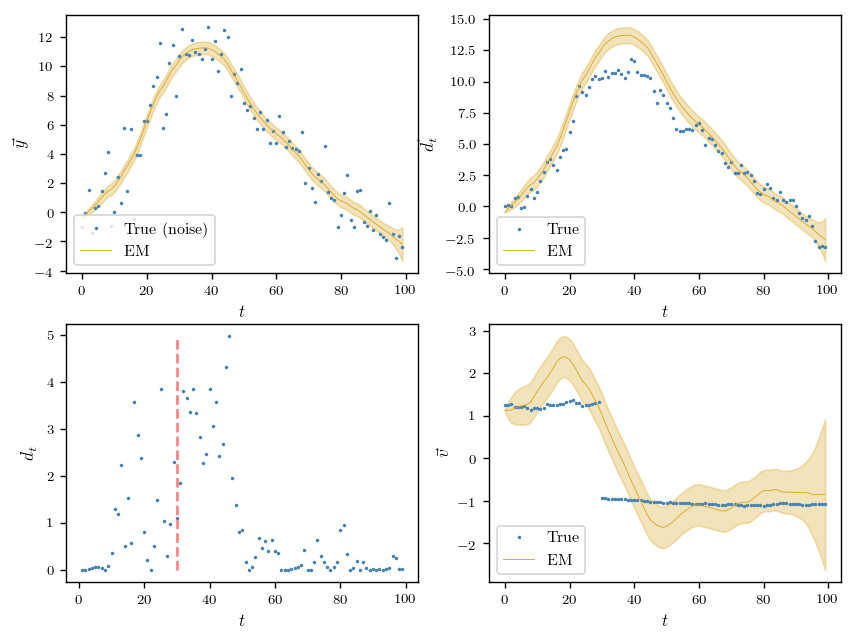

In [319]:
plt.figure(figsize=(8, 6))

legend_loc = "lower left"

plt.subplot(2, 2, 1)

# Plot data with noise
plt.plot(y_2.T, '.', color=colors[0], markersize=2, label="True (noise)")

# Plot smoothed state computed using EM
plt.plot(y_hat_2.T, color=colors[2], label="EM", linewidth=0.5)
plt.fill_between(range(T_2),
                 (y_hat_2 - 2*y_em_err_2).flatten().T,
                 (y_hat_2 + 2*y_em_err_2).flatten().T,
                 linewidth=1,
                 alpha=0.3,
                 color=colors[2])

#plt.title("Observations")
plt.xlabel(r"$t$")
plt.ylabel(r"$\vec{y}$")
plt.legend(loc=legend_loc)

########################

plt.subplot(2, 2, 2)

# Plot true hidden state
plt.plot(x_2[0, :].T, '.', color=colors[0], markersize=2, label="True")

# Plot infered hidden state with error bars
plt.plot(aug_ssm_2.x_smooth[0, :].T, color=colors[2], linewidth=0.5, label="EM")
plt.fill_between(range(T_2),
                 (aug_ssm_2.x_smooth[0, :] - 2*aug_ssm_2.sigma_smooth[:, 0, 0]).flatten().T,
                 (aug_ssm_2.x_smooth[0, :] + 2*aug_ssm_2.sigma_smooth[:, 0, 0]).flatten().T,
                 linewidth=1,
                 alpha=0.3,
                 color=colors[2])

#plt.title("Hidden state")
plt.xlabel(r"$t$")
plt.ylabel(r"$\vec{d}_t$")
plt.legend(loc=legend_loc)

########################

plt.subplot(2, 2, 3)

# Mark true change point
plt.plot([T_2a, T_2a], [0, max(d_2)], '--r', alpha=0.5)

plt.plot(range(1, T_2), d_2, '.', markersize=2, color=colors[0])

#plt.title("Change detection statistic")
plt.xlabel(r"$t$")
plt.ylabel(r"$d_t$")

########################

plt.subplot(2, 2, 4)

# Plot true hidden state's derivative
plt.plot(x_2[1, :].T, '.', color=colors[0], markersize=2, label="True")
# Plot infered hidden state's derivative
plt.plot(aug_ssm_2.x_smooth[1, :].T, color=colors[2], linewidth=0.5, label="EM")
plt.fill_between(range(T_2),
                 (aug_ssm_2.x_smooth[1, :] - 2*aug_ssm_2.sigma_smooth[:, 1, 1]).flatten().T,
                 (aug_ssm_2.x_smooth[1, :] + 2*aug_ssm_2.sigma_smooth[:, 1, 1]).flatten().T,
                 linewidth=1,
                 alpha=0.3,
                 color=colors[2])

#plt.title("Hidden state's derivative")
plt.xlabel(r"$t$")
plt.ylabel(r"$\vec{v}$")
plt.legend(loc=legend_loc)

### Augmented SSM EM, switching
Not sure this is correct. Should probably alternate between recomputing $d_t$ and running augmented SSM EM.

In [315]:
# Set a threshold for the change detection variable
d_thresh = 5.0

# Find change (if there is one)
t_change = np.argmax(d_2 > d_thresh)

In [316]:
# Rerun EM before this point
aug_ssm_2a = Augmented_SSM(y_2[:, :t_change], dt, 1, v=np.zeros([1, t_change]))#, ss=ss_2)
aug_ssm_2a.em(100)

# Get observation estimates and error band
y_hat_2a = aug_ssm_2a.get_y_hat()
y_em_err_2a = np.einsum("ij,ki,tjk->it", aug_ssm_2a.Cs[0], aug_ssm_2a.Cs[0].T, aug_ssm_2a.sigma_smooth)

In [317]:
# Rerun EM starting at this point
aug_ssm_2b = Augmented_SSM(y_2[:, t_change:], dt, 1, v=np.zeros([1, T_2 - t_change]))#, ss=ss_2)
aug_ssm_2b.em(100)

# Get observation estimates and error band
y_hat_2b = aug_ssm_2b.get_y_hat()
y_em_err_2b = np.einsum("ij,ki,tjk->it", aug_ssm_2b.Cs[0], aug_ssm_2b.Cs[0].T, aug_ssm_2b.sigma_smooth)

#### Plot results

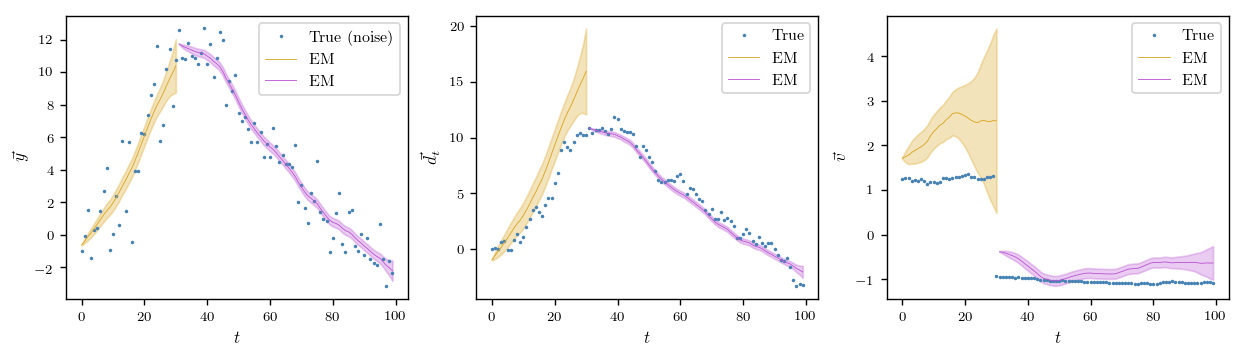

In [321]:
plt.figure(figsize=(12, 3))

legend_loc = "upper right"

plt.subplot(1, 3, 1)

# Plot data with noise
plt.plot(y_2.T, '.', color=colors[0], markersize=2, label="True (noise)")

# Plot smoothed state computed using EM
plt.plot(y_hat_2a.T, color=colors[2], label="EM", linewidth=0.5)
plt.fill_between(range(t_change),
                 (y_hat_2a - 2*y_em_err_2a).flatten().T,
                 (y_hat_2a + 2*y_em_err_2a).flatten().T,
                 linewidth=1,
                 alpha=0.3,
                 color=colors[2])
plt.plot(range(t_change, T_2), y_hat_2b.T, color=colors[3], label="EM", linewidth=0.5)
plt.fill_between(range(t_change, T_2),
                 (y_hat_2b - 2*y_em_err_2b).flatten().T,
                 (y_hat_2b + 2*y_em_err_2b).flatten().T,
                 linewidth=1,
                 alpha=0.3,
                 color=colors[3])

#plt.title("Observations")
plt.xlabel(r"$t$")
plt.ylabel(r"$\vec{y}$")
plt.legend(loc=legend_loc)

########################

plt.subplot(1, 3, 2)

# Plot true hidden state
plt.plot(x_2[0, :].T, '.', color=colors[0], markersize=2, label="True")

# Plot infered hidden state with error bars
plt.plot(aug_ssm_2a.x_smooth[0, :].T, color=colors[2], linewidth=0.5, label="EM")
plt.fill_between(range(t_change),
                 (aug_ssm_2a.x_smooth[0, :] - 2*aug_ssm_2a.sigma_smooth[:, 0, 0]).flatten().T,
                 (aug_ssm_2a.x_smooth[0, :] + 2*aug_ssm_2a.sigma_smooth[:, 0, 0]).flatten().T,
                 linewidth=1,
                 alpha=0.3,
                 color=colors[2])
plt.plot(range(t_change, T_2), aug_ssm_2b.x_smooth[0, :].T, color=colors[3], linewidth=0.5, label="EM")
plt.fill_between(range(t_change, T_2),
                 (aug_ssm_2b.x_smooth[0, :] - 2*aug_ssm_2b.sigma_smooth[:, 0, 0]).flatten().T,
                 (aug_ssm_2b.x_smooth[0, :] + 2*aug_ssm_2b.sigma_smooth[:, 0, 0]).flatten().T,
                 linewidth=1,
                 alpha=0.3,
                 color=colors[3])

#plt.title("Hidden state")
plt.xlabel(r"$t$")
plt.ylabel(r"$\vec{d}_t$")
plt.legend(loc=legend_loc)

########################

plt.subplot(1, 3, 3)

# Plot true hidden state's derivative
plt.plot(x_2[1, :].T, '.', color=colors[0], markersize=2, label="True")
# Plot infered hidden state's derivative
plt.plot(aug_ssm_2a.x_smooth[1, :].T, color=colors[2], linewidth=0.5, label="EM")
plt.fill_between(range(t_change),
                 (aug_ssm_2a.x_smooth[1, :] - 2*aug_ssm_2a.sigma_smooth[:, 1, 1]).flatten().T,
                 (aug_ssm_2a.x_smooth[1, :] + 2*aug_ssm_2a.sigma_smooth[:, 1, 1]).flatten().T,
                 linewidth=1,
                 alpha=0.3,
                 color=colors[2])
plt.plot(range(t_change, T_2), aug_ssm_2b.x_smooth[1, :].T, color=colors[3], linewidth=0.5, label="EM")
plt.fill_between(range(t_change, T_2),
                 (aug_ssm_2b.x_smooth[1, :] - 2*aug_ssm_2b.sigma_smooth[:, 1, 1]).flatten().T,
                 (aug_ssm_2b.x_smooth[1, :] + 2*aug_ssm_2b.sigma_smooth[:, 1, 1]).flatten().T,
                 linewidth=1,
                 alpha=0.3,
                 color=colors[3])

#plt.title("Hidden state's derivative")
plt.xlabel(r"$t$")
plt.ylabel(r"$\vec{v}$")
plt.legend(loc=legend_loc)

# Tests on real data

## Load Feather data

In [322]:
# Info on what's available
feather_wsns = ["KTL", "GRZL"]

# Choose a network
df_feather_ktl = pd.read_csv("../raw_data/feather_data/%s.csv" % feather_wsns[0])

# Extract values
y_sd_raw = df_feather_ktl[["snowdepth_%i" % s for s in range(1, 12)]].values
y_t_raw = df_feather_ktl[["air_temp_%i" % s for s in range(1, 12)]].values
y_rh_raw = df_feather_ktl[["rel_humidity_%i" % s for s in range(1, 12)]].values
y_rad_raw = df_feather_ktl["solar_rad_8"].values
times = pd.to_datetime(df_feather_ktl["time"])

# Convert times to CA ones
utc_zone = tz.gettz("UTC")
ca_zone = tz.gettz("America/Los_Angeles")
times = np.array([t.replace(tzinfo=utc_zone).astimezone(ca_zone) for t in times])

# Get dawn/dusk times
def get_dawn_dusk(ts):
    a = Astral()
    a.solar_depression = "civil"
    city = a["Sacramento"]
    
    return np.array([city.sun(t)["sunrise"] for t in ts]), np.array([city.sun(t)["sunset"] for t in ts])

(75, 110)

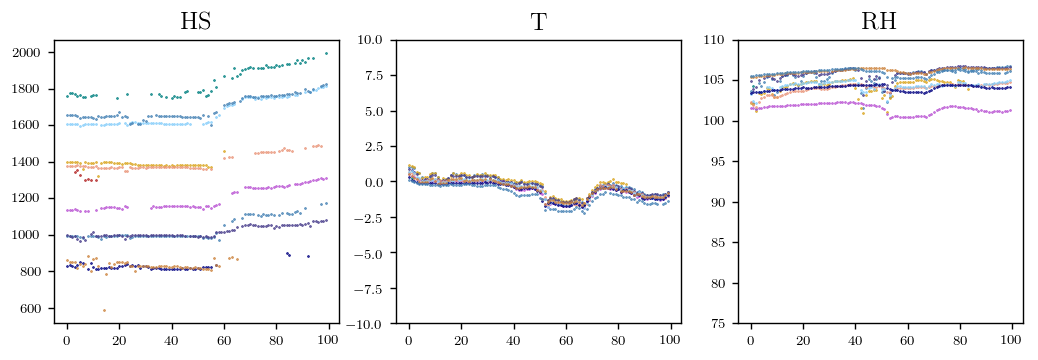

In [346]:
plt.figure(figsize=(10, 3))

ti = 16350#, 17000
tf = ti + 100

plt.subplot(1, 3, 1)
plt.plot(y_sd_raw[ti:tf, :], '.', markersize=1)
plt.title("HS")

plt.subplot(1, 3, 2)
plt.plot(y_t_raw[ti:tf, :], '.', markersize=1)
plt.title("T")
plt.ylim(-10, 10)

plt.subplot(1, 3, 3)
plt.plot(y_rh_raw[ti:tf, :], '.', markersize=1)
plt.title("RH")
plt.ylim(75, 110)

## Run SSM

In [388]:
# Choose some data
ti = 16390#, 17000
tf = ti + 30
sensors = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10]
y = y_sd_raw[ti:tf, sensors].T # note the transpose!

# Set controls
u = np.zeros([1, tf-ti])
v = np.ones([1, tf-ti]) # should be ones

# Set number of latent factors
n_HS = 2

real_assm_1 = Augmented_SSM(y, dt=0.25, n_HS=n_HS, u=u, v=v)

In [389]:
# Run EM!
real_assm_1.em(num_it=100)
y_hat = real_assm_1.get_y_hat()

In [390]:
# Compute change detection statistics
d_real = np.einsum("it,tij,jt->t",
                real_assm_1.x_smooth[n_HS:, 1:] - real_assm_1.x_pred[n_HS:, :],
                np.array([np.linalg.pinv(real_assm_1.sigma_pred[t-1, n_HS:, n_HS:]
                                         - real_assm_1.sigma_smooth[t, n_HS:, n_HS:]) for t in range(1, tf-ti)]),
                real_assm_1.x_smooth[n_HS:, 1:] - real_assm_1.x_pred[n_HS:, :])

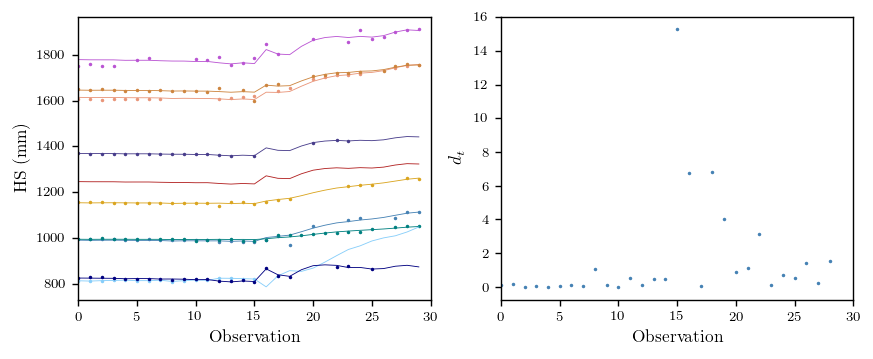

In [391]:
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
# Snow depth
for s, c in zip(range(len(sensors)), colors):
    plt.plot(y_hat[s, :], '-', linewidth=0.5, color=c)
    plt.plot(y[s, :], '.', markersize=2.0, color=c)

plt.xlim(0, tf-ti)
plt.xlabel("Observation")
plt.ylabel("HS (mm)")

plt.subplot(1, 2, 2)

# Change statistic
plt.plot(d_real, '.', markersize=2.0)

plt.xlim(0, tf-ti)
plt.xlabel("Observation")
plt.ylabel(r"$d_t$")

### Willsky's generalized likelihood ratio

In [404]:
N, T = y.shape
A = real_assm_1.A
C = real_assm_1.Cs[0]
Q = real_assm_1.Qs[0]
R = real_assm_1.Rs[0]

In [408]:
# Compute Kalman gain
# FUCK, there is an indexing error...
K = np.zeros([T-1, 2*n_HS, N])

for t in range(1, T):
    S_inv = np.linalg.pinv(np.dot(np.dot(C, real_assm_1.sigma_pred[t-1]), C.T) + R)
    K[t-1, :, :] = np.dot(np.dot(real_assm_1.sigma_pred[t-1], C.T), S_inv)

In [397]:
# Disturbance to precipitation rate
dist = np.asarray([])

alpha = np.zeros([tf-ti, tf-ti, 2*n_HS])



NameError: name 'alpha' is not defined

In [396]:
a = np.zeros(2*[tf-ti])

In [ ]:
for t in range(tf-ti):
    for theta in range(tf-ti):
        a[t, theta] = np.einsum("")